In [1]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from simulated_utils import compare

In [2]:
%matplotlib inline

In [3]:
import gym
from gym import spaces
from gym.utils import seeding

class RouletteEnv(gym.Env):
    """Simple roulette environment
    The roulette wheel has 37 spots. If the bet is 0 and a 0 comes up,
    you win a reward of 35. If the parity of your bet matches the parity
    of the spin, you win 1. Otherwise you receive a reward of -1.
    The long run reward for playing 0 should be -1/37 for any state
    The last action (38) stops the rollout for a return of 0 (walking away)
    """
    def __init__(self, spots=37, noise_std=1e-4):
        self.n = spots + 1
        self.action_dim = self.n
        self.action_space = spaces.Discrete(self.n)
        self.observation_space = spaces.Discrete(1)
        self.noise_std = noise_std
        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        action = np.array(action).item()
        assert self.action_space.contains(action)
        noise = np.random.randn() * self.noise_std
        if action == self.n - 1:
            # observation, reward, done, info
            return np.zeros(1), 0 + noise, True, {}

        # N.B. np.random.randint draws from [A, B) while random.randint draws from [A,B]
        val = self.np_random.randint(0, self.n - 1)
        if val == action == 0:
            reward = self.n - 3.0
        elif val != 0 and action != 0 and val % 2 == action % 2:
            reward = 1.0
        else:
            reward = -1.0
        return np.zeros(1), reward + noise, False, {}

    def reset(self):
        return np.zeros(1)

In [4]:
 def plot_results(data, n=37):
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    #sns.lineplot(data=data, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=1000)
    sns.lineplot(data=data, x='iter', y='pd_param_0_mean', hue='method', ax=axes[0], n_boot=1000)
    sns.lineplot(data=data, x='iter', y=f"pd_param_{n}_mean", hue='method', ax=axes[1], n_boot=1000)
    data['pd_param_1_to_36_mean'] = 1.0 - data['pd_param_0_mean'] - data[f"pd_param_{n}_mean"]
    sns.lineplot(data=data, x='iter', y='pd_param_1_to_36_mean', hue='method', ax=axes[2], n_boot=1000)
    #axes[0][0].set_ylabel('Mean Reward')
    axes[0].set_ylabel('Probability of Betting on 0')
    axes[1].set_ylabel('Probability of Not Playing')
    axes[2].set_ylabel(f"Probability of Betting on 1-{n-1}")

    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        ax.get_legend().remove()
    fig.legend(handles[1:], labels[1:], loc='upper center', title='Method', ncol=4)
    plt.show()
    
    sns.lineplot(data=data, x='iter', y='mean_reward', hue='method', n_boot=1000)
    plt.ylim([0, 1])
    plt.show()

In [5]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [9]:
new_to_old_params = {'kl_penalty_direction': 'new_to_old', 'kl_penalty_coeff': 0.01, 'clip_eps': None}
old_to_new_params = {'kl_penalty_direction': 'old_to_new', 'kl_penalty_coeff': 0.01, 'clip_eps': None}
clip_params = {'kl_penalty_coeff': 0., 'clip_eps': 0.2}
plain_params = {'kl_penalty_coeff': 0., 'clip_eps': None}

comparisons = {
    'Reverse KL': new_to_old_params,
    #'Forward KL': old_to_new_params,
     'Clipping': clip_params,
     #'Unregularized': plain_params
}

/home/eecs/chloehsu/ppo_ablation/code-for-paper/analysis/simulated_utils.py:289: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


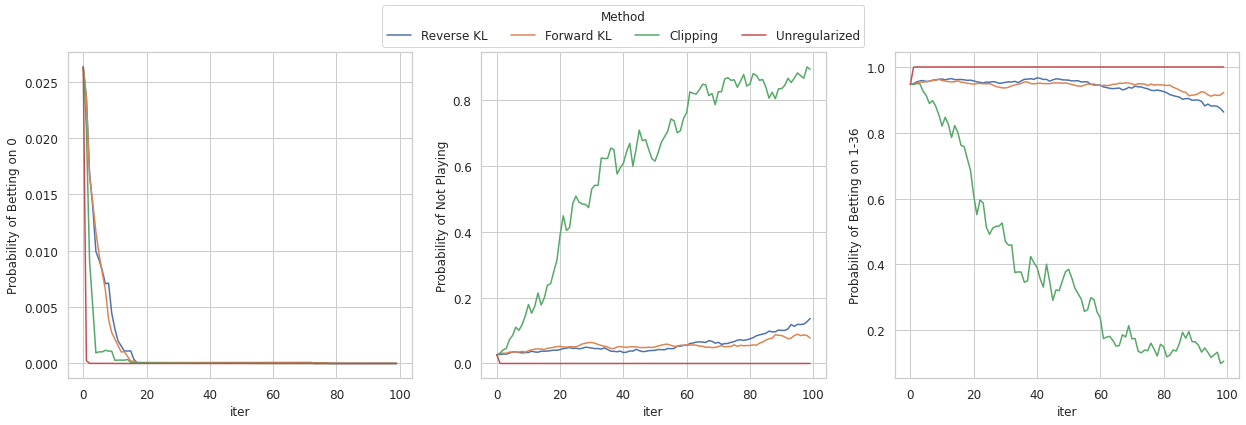

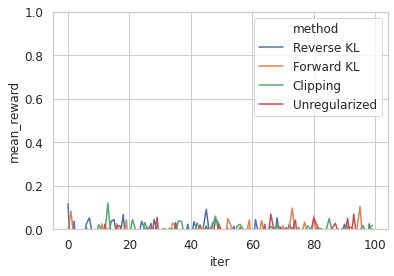

In [10]:
env = RouletteEnv()
data_roulette = compare(env, 'discrete', n_steps=100, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

plot_results(data_roulette)

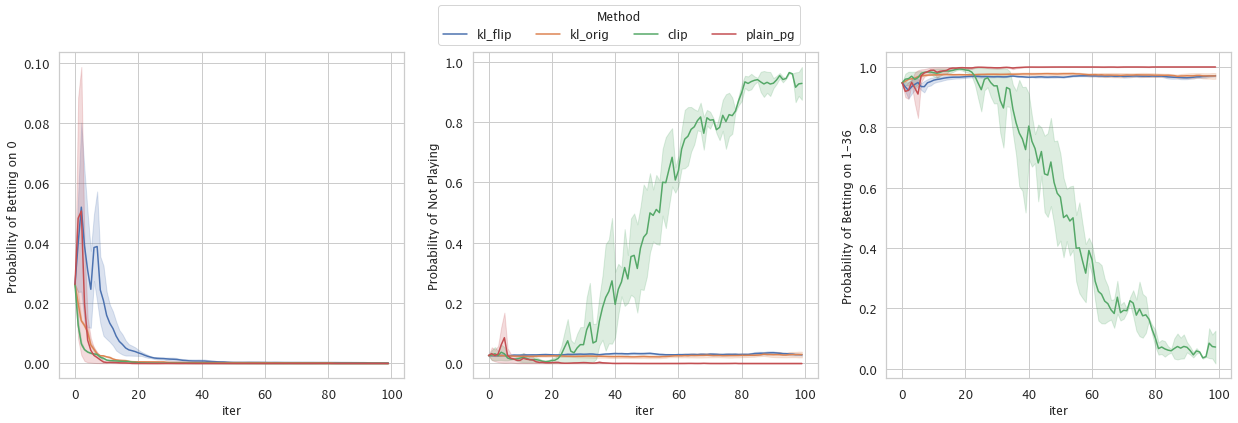

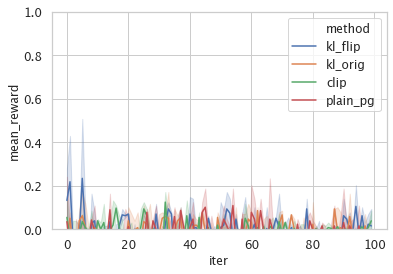

In [20]:
env = RouletteEnv()
data_roulette = compare(env, 'discrete', n_steps=100, repeats=2,
               lr=1e-1, batch_size=128, num_minibatches=1, ppo_epochs=10)

plot_results(data_roulette)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


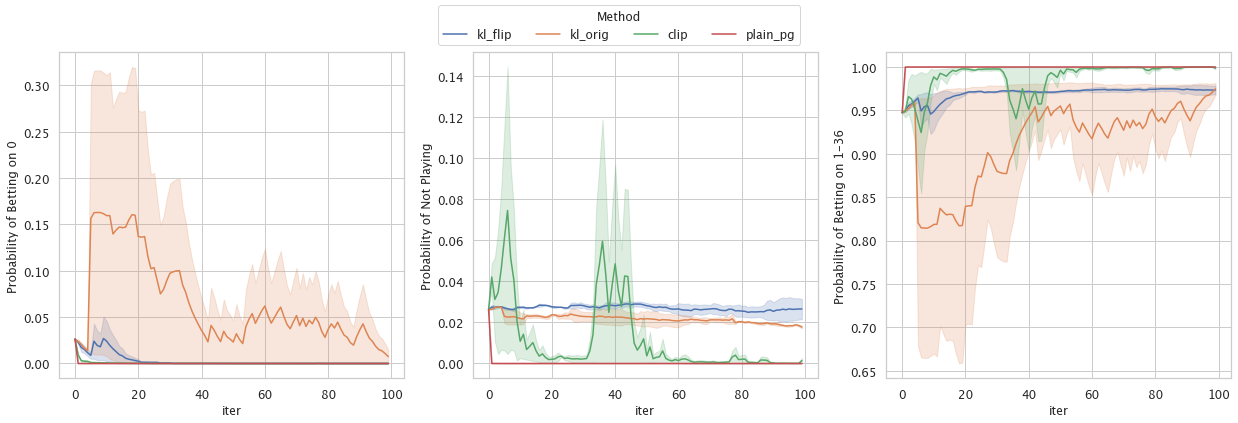

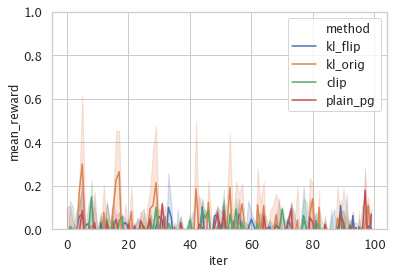

In [22]:
env = RouletteEnv()
data_roulette = compare(env, 'discrete', n_steps=100, repeats=2,
               lr=1e-1, batch_size=128, num_minibatches=1, ppo_epochs=100)

plot_results(data_roulette)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


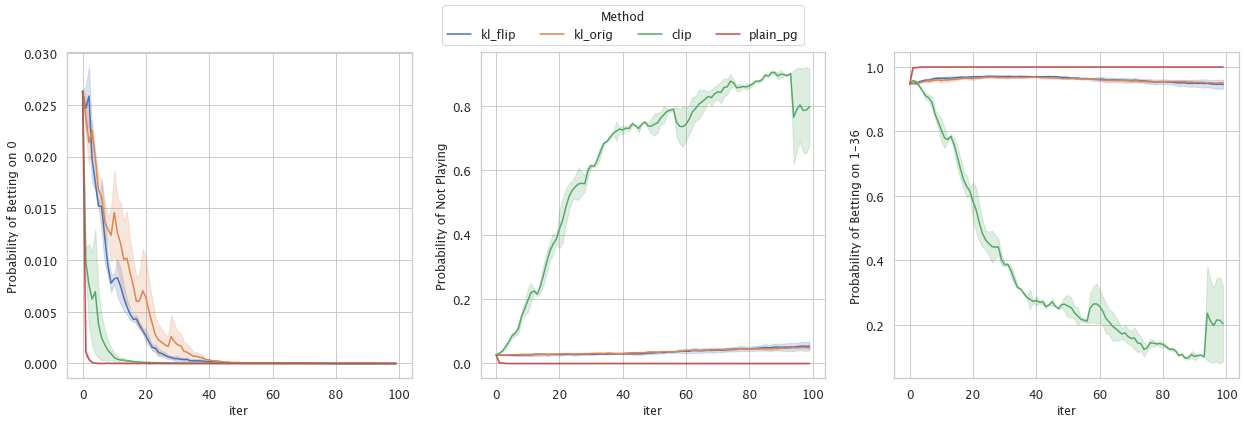

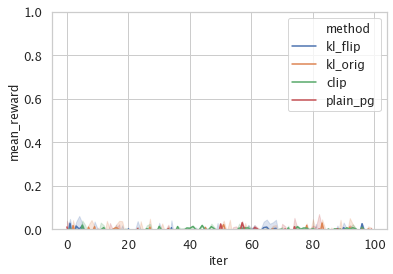

In [7]:
env = RouletteEnv()
data_roulette = compare(env, 'discrete', n_steps=100, repeats=2,
               lr=1e-1, batch_size=1024, num_minibatches=8, ppo_epochs=10, adv_norm=False)

plot_results(data_roulette)

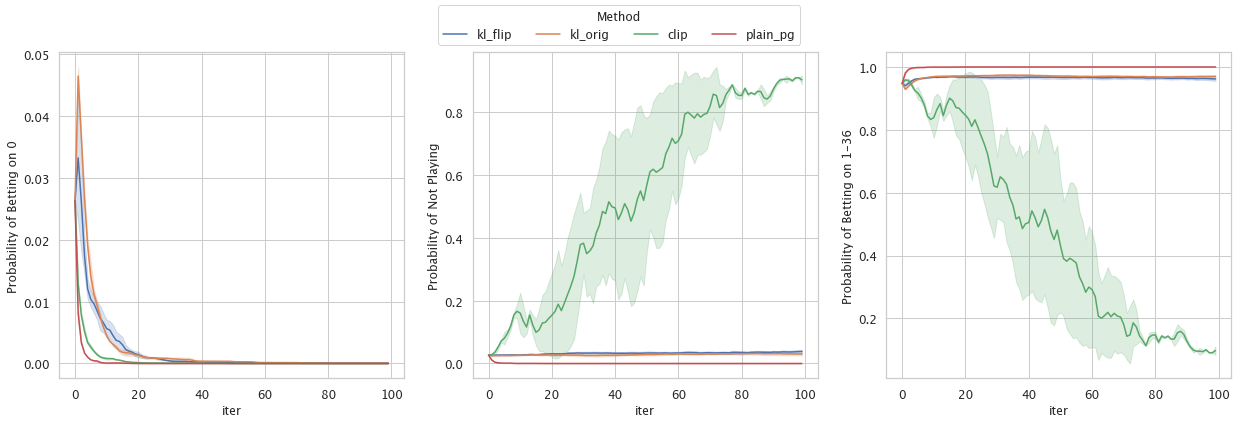

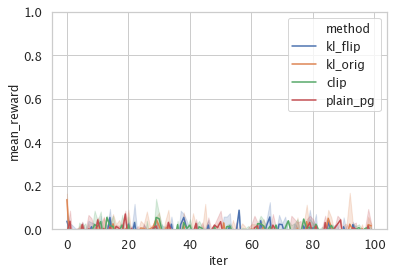

In [10]:
env = RouletteEnv()
data_roulette = compare(env, 'discrete', n_steps=100, repeats=2,
               lr=1e-1, batch_size=256, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette)

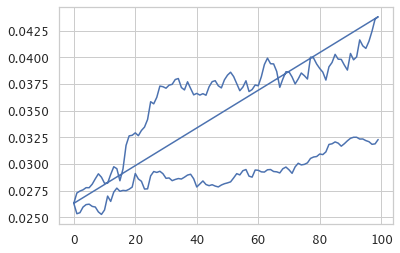

In [24]:
plt.plot(filter_df(data_roulette, method='kl_flip').pd_param_37_mean)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


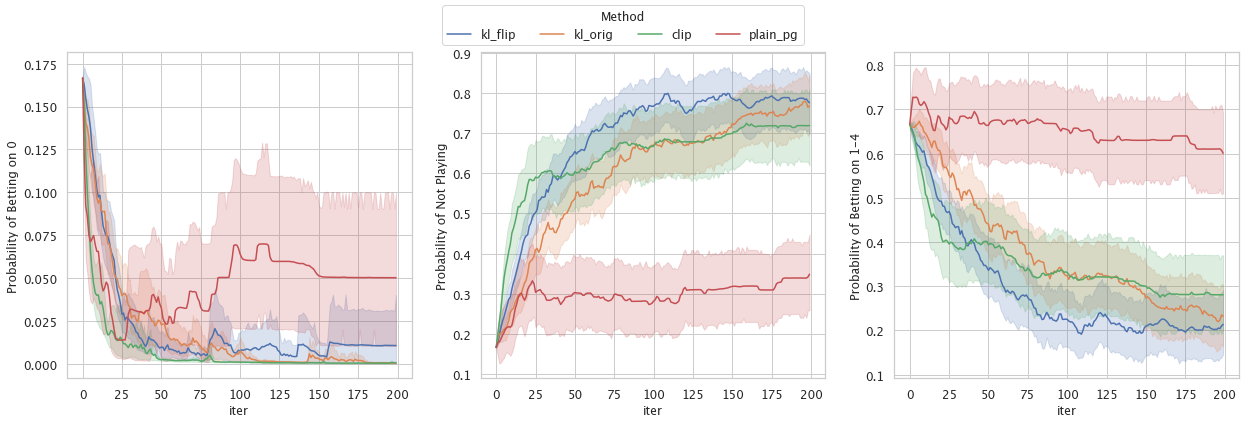

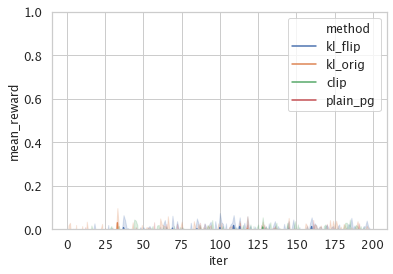

In [35]:
env = RouletteEnv(spots=5)
data_roulette = compare(env, 'discrete', n_steps=200, repeats=100,
               lr=1e-1, batch_size=4, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=5)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


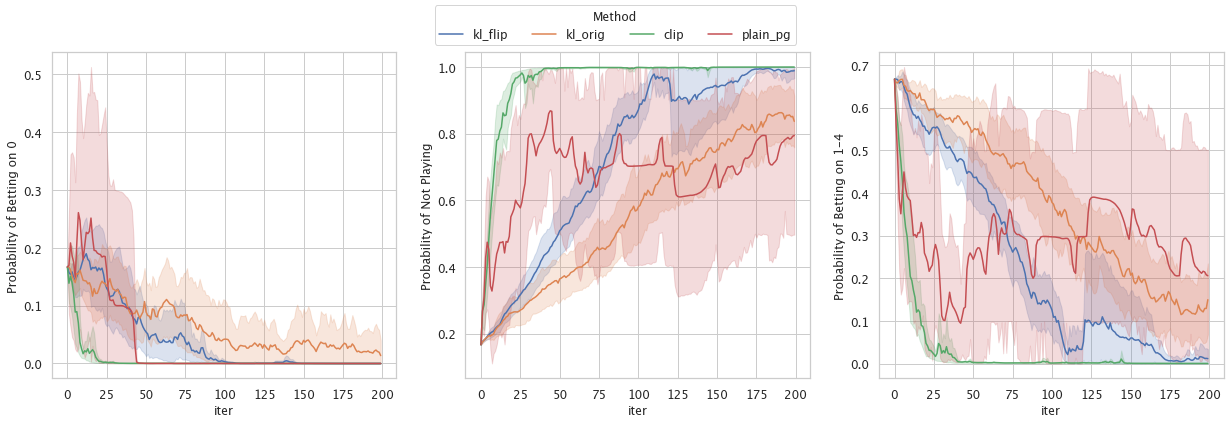

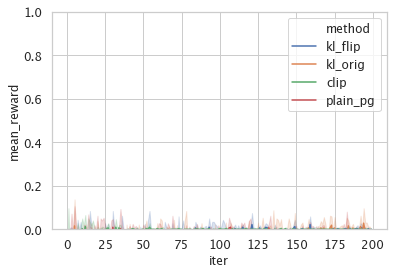

In [36]:
env = RouletteEnv(spots=5)
data_roulette = compare(env, 'discrete', n_steps=200, repeats=10,
               lr=1e-1, batch_size=32, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=5)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


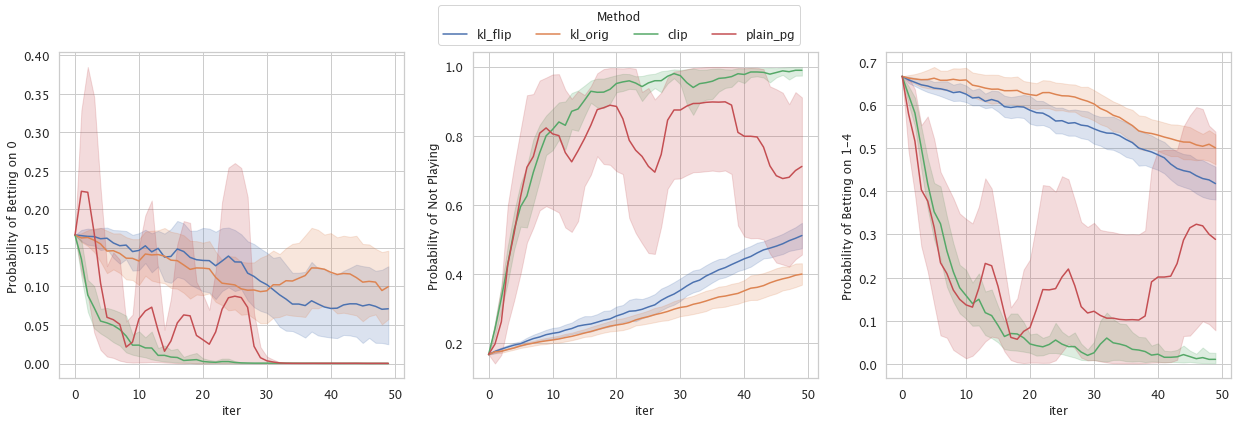

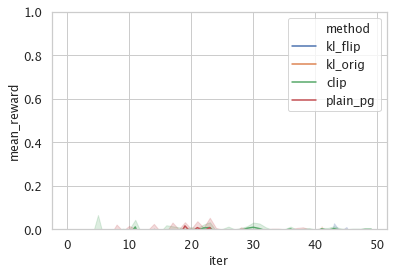

In [37]:
env = RouletteEnv(spots=5)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=64, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=5)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


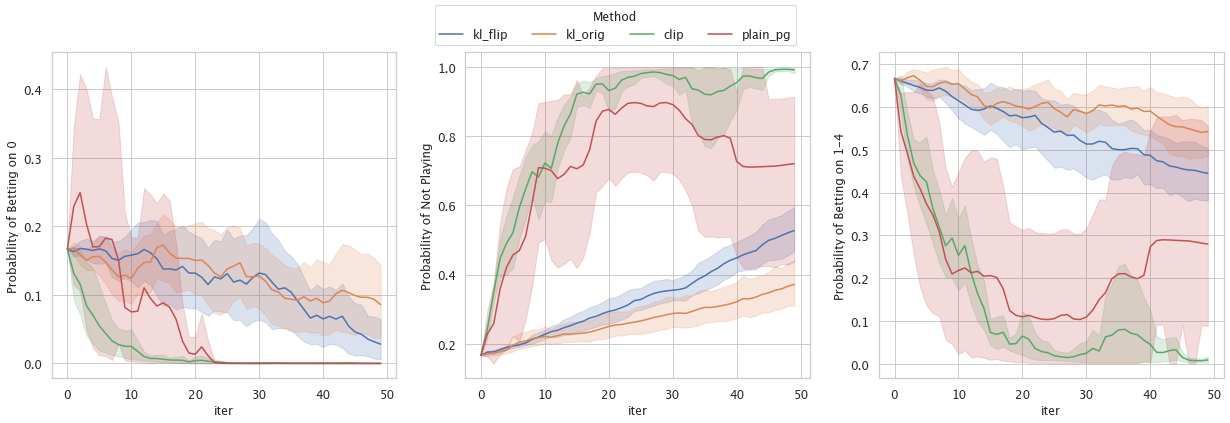

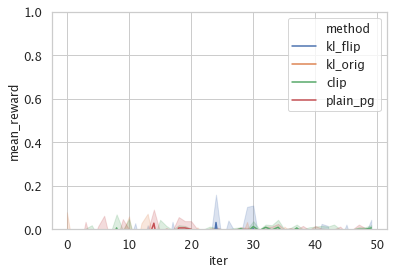

In [38]:
env = RouletteEnv(spots=5)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=32, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=5)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


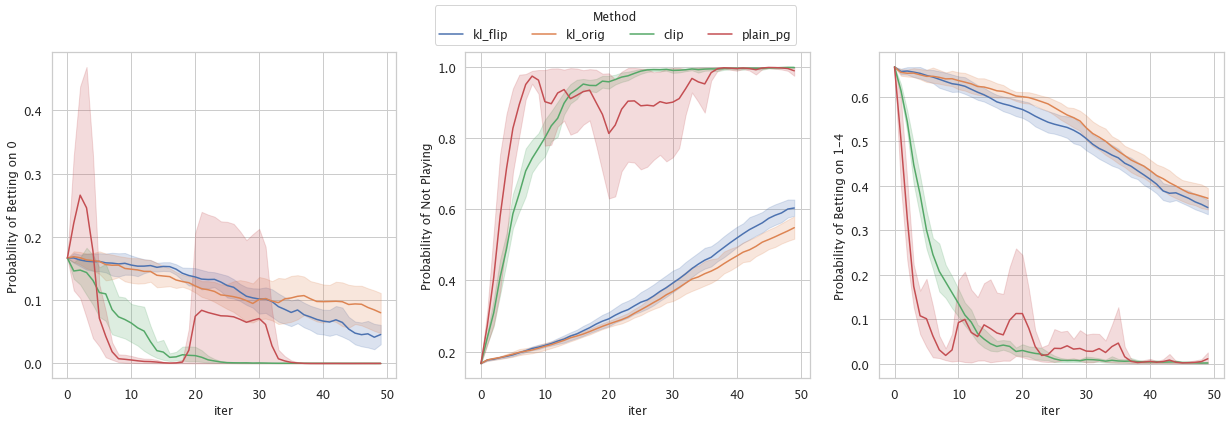

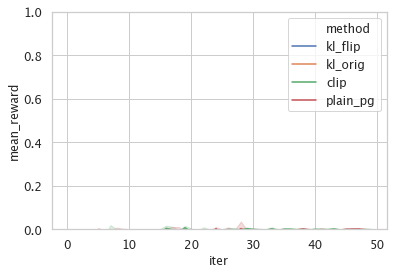

In [39]:
env = RouletteEnv(spots=5)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=128, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=5)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


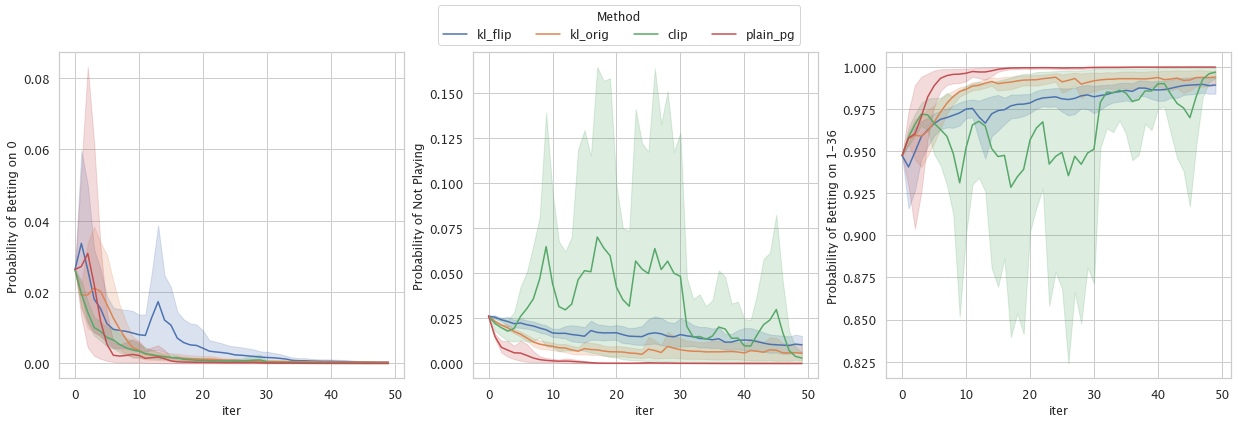

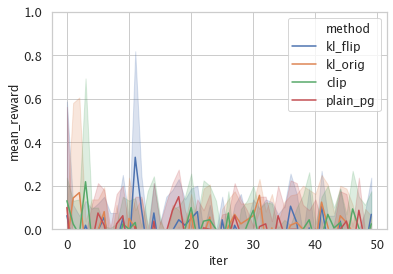

In [40]:
env = RouletteEnv(spots=37)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=16, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=37)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


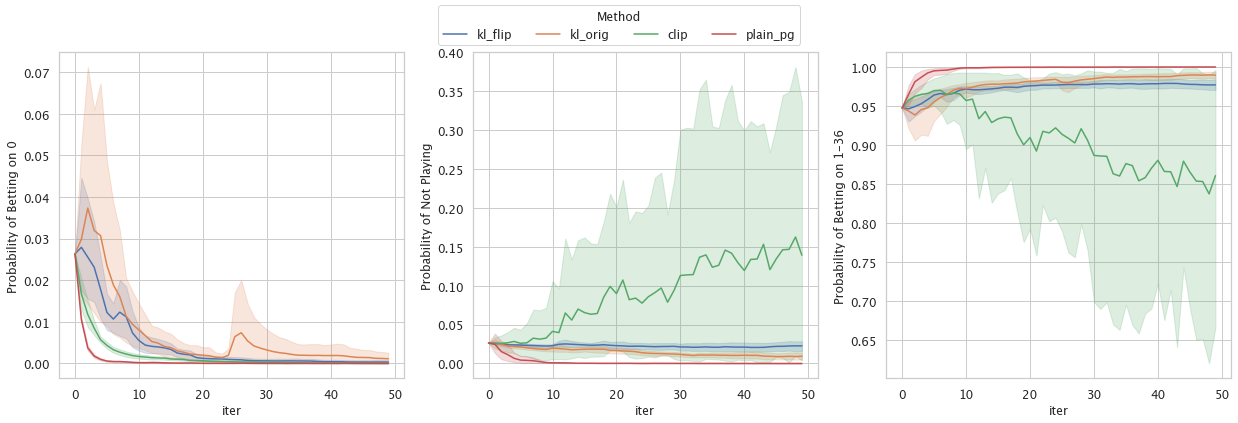

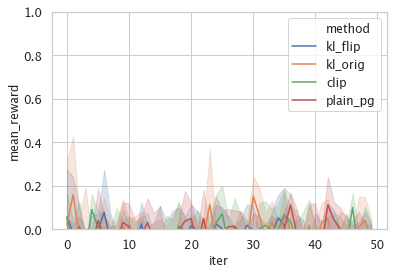

In [41]:
env = RouletteEnv(spots=37)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=32, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=37)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


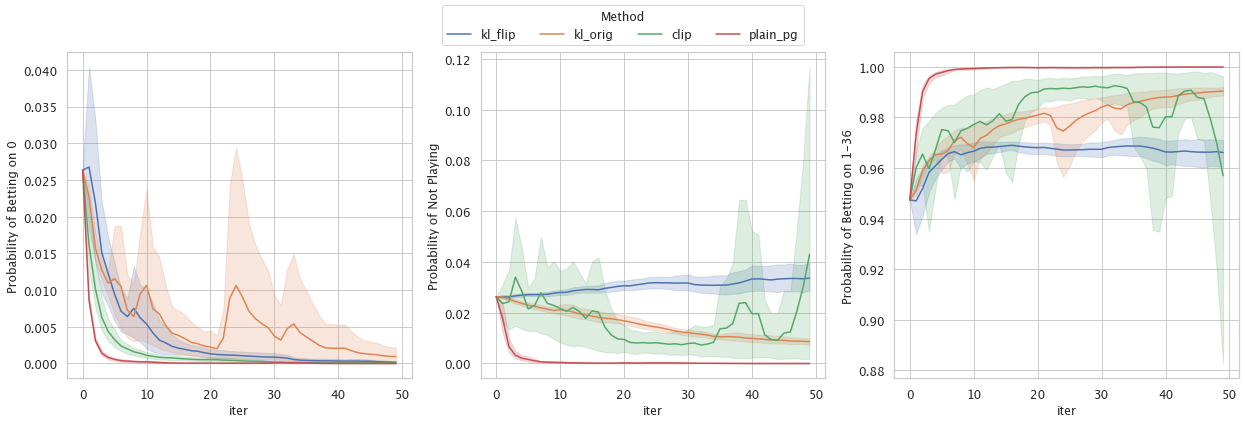

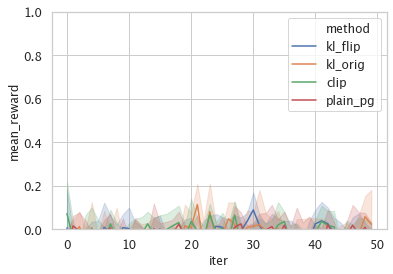

In [42]:
env = RouletteEnv(spots=37)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=64, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=37)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


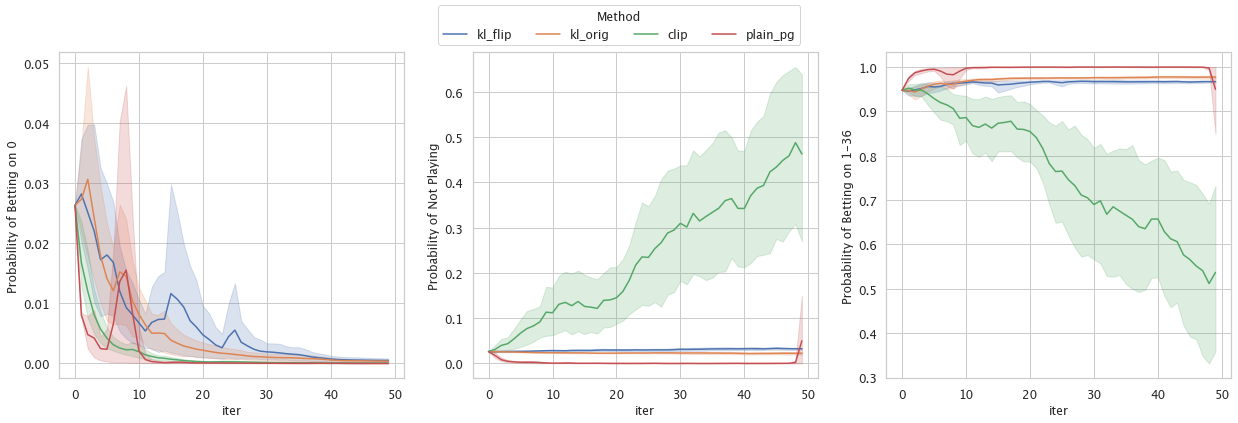

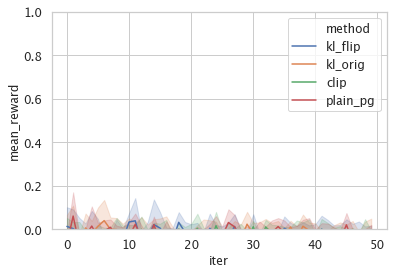

In [43]:
env = RouletteEnv(spots=37)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=128, num_minibatches=1, ppo_epochs=10, adv_norm=True)
plot_results(data_roulette, n=37)

/Users/cusgadmion/Documents/ppo-mw/code/analysis/simulated_utils.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self.logits).repeat(


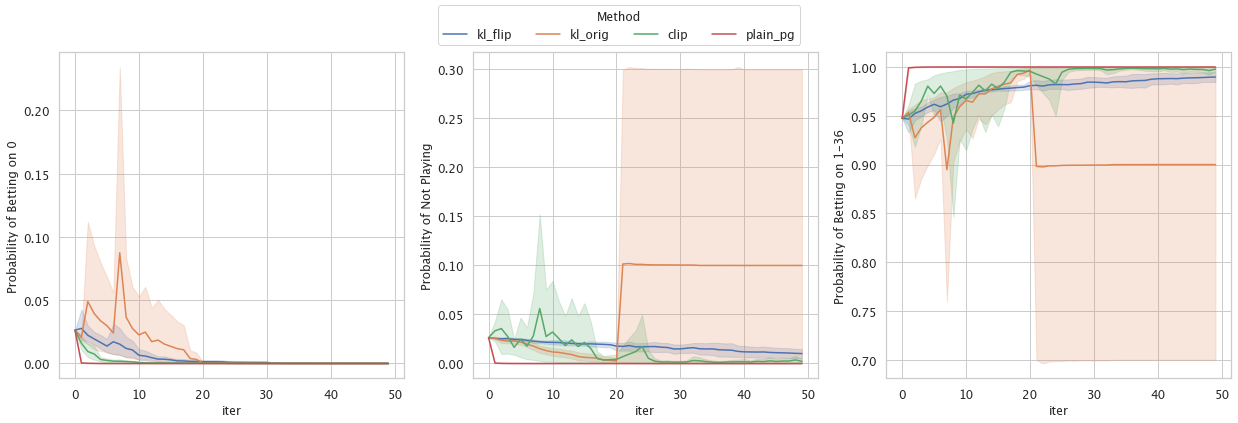

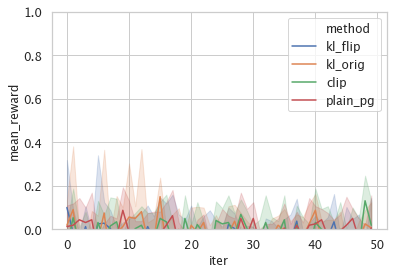

In [44]:
env = RouletteEnv(spots=37)
data_roulette = compare(env, 'discrete', n_steps=50, repeats=10,
               lr=1e-1, batch_size=32, num_minibatches=1, ppo_epochs=40, adv_norm=True)
plot_results(data_roulette, n=37)